# Solution

## Goal
Estimate the unknown upper bound parameter $d$ from $N$ i.i.d. samples:

$$X_1,\dots,X_N \sim \mathrm{Uniform}(0,d).$$

## Problem Statement
Given $N$ samples from a uniform distribution on $[0,d]$, how would you estimate $d$?

## High-level idea
- The MLE is $\hat d_{\text{MLE}} = X_{\max}$ where $X_{\max}=\max_i X_i$, but it is biased downward.
- Use the order-statistic distribution of $X_{\max}$ to compute $\mathbb{E}[X_{\max}]$.
- Apply a bias correction to get an unbiased estimator:
  $$\hat d=\frac{N+1}{N}X_{\max}.$$

We’ll derive this estimator and then verify it via simulation (and optionally build a confidence interval for $d$ by inverting the distribution of $X_{\max}$).

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)


def draw_uniform_samples(d: float, n: int, n_trials: int, rng: np.random.Generator) -> np.ndarray:
    """Draw n_trials samples of size n from Uniform(0, d). Returns shape (n_trials, n)."""
    if d <= 0:
        raise ValueError("d must be positive")
    if n < 1:
        raise ValueError("n must be >= 1")
    if n_trials < 1:
        raise ValueError("n_trials must be >= 1")
    return rng.uniform(0.0, d, size=(n_trials, n))


def estimators_from_samples(samples: np.ndarray) -> dict:
    """Compute several estimators of d from a (n_trials, n) sample matrix."""
    n_trials, n = samples.shape
    x_max = samples.max(axis=1)
    x_bar = samples.mean(axis=1)

    return {
        "n": n,
        "x_max": x_max,
        "d_mle_xmax": x_max,  # MLE
        "d_unbiased_xmax": (n + 1) / n * x_max,
        "d_unbiased_mean": 2 * x_bar,  # also unbiased since E[X]=d/2
    }


def summarize_estimates(d_true: float, est: np.ndarray, name: str) -> dict:
    """Return mean, bias, std for an estimator array."""
    mean = float(np.mean(est))
    bias = mean - float(d_true)
    std = float(np.std(est, ddof=1))
    return {"estimator": name, "mean": mean, "bias": bias, "std": std}


plt.rcParams.update({"figure.figsize": (9, 5), "axes.grid": True})

## Derivation via order statistics

### Step 1 — Distribution of $X_{\max}$
For $X \sim \mathrm{Uniform}(0,d)$:

- PDF: $f(x)=\frac{1}{d}$ for $0\le x\le d$.
- CDF: $F(x)=\frac{x}{d}$ for $0\le x\le d$.

Let $X_{\max}=\max(X_1,\dots,X_N)$. For $0\le x\le d$:

$$\mathbb{P}(X_{\max}\le x)=\prod_{i=1}^N \mathbb{P}(X_i\le x)=\left(\frac{x}{d}\right)^N.$$

So the CDF of the maximum is:

$$F_{\max}(x)=\left(\frac{x}{d}\right)^N,\quad 0\le x\le d.$$

### Step 2 — PDF of $X_{\max}$
Differentiate the CDF:

$$f_{\max}(x)=\frac{d}{dx}F_{\max}(x)=\frac{N x^{N-1}}{d^N},\quad 0\le x\le d.$$

### Step 3 — Expectation of $X_{\max}$

$$\mathbb{E}[X_{\max}]=\int_0^d x\, f_{\max}(x)\,dx
=\int_0^d x\,\frac{N x^{N-1}}{d^N}\,dx
=\frac{N}{d^N}\int_0^d x^N\,dx
=\frac{N}{d^N}\cdot\frac{d^{N+1}}{N+1}
=\frac{N}{N+1}d.$$

### Step 4 — Unbiased estimator for $d$
Rearrange:

$$d=\frac{N+1}{N}\,\mathbb{E}[X_{\max}].$$

Replacing the expectation with the observed statistic $X_{\max}$ gives an unbiased estimator:

$$\boxed{\hat d=\frac{N+1}{N}X_{\max}}.$$

Notes:
- $\hat d_{\text{MLE}}=X_{\max}$ is the maximum likelihood estimator, but it is biased with
  $$\mathbb{E}[X_{\max}] - d = -\frac{d}{N+1}.$$

In [6]:
# --- Simulation: compare estimators ---

d_true = 10.0
N = 5
n_trials = 200_000

samples = draw_uniform_samples(d=d_true, n=N, n_trials=n_trials, rng=rng)
ests = estimators_from_samples(samples)

summary = pd.DataFrame(
    [
        summarize_estimates(d_true, ests["d_mle_xmax"], "MLE: X_max"),
        summarize_estimates(d_true, ests["d_unbiased_xmax"], "Unbiased: (N+1)/N * X_max"),
        summarize_estimates(d_true, ests["d_unbiased_mean"], "Unbiased: 2 * mean"),
    ]
).set_index("estimator")

summary

,mean,bias,std
estimator,,,
MLE: X_max,8.333145,-1.666855,1.408937
Unbiased: (N+1)/N * X_max,9.999773,-0.000227,1.690725
Unbiased: 2 * mean,10.000530,0.000530,2.581741


## Visual checks and how bias shrinks with $N$

Two quick sanity checks:
1. For fixed $N$, the MLE $X_{\max}$ should be biased downward.
2. The corrected estimator $\frac{N+1}{N}X_{\max}$ should be (approximately) unbiased in simulation.

We’ll also look at how the bias of $X_{\max}$ decreases as $N$ grows (since $\mathbb{E}[X_{\max}]=\frac{N}{N+1}d$).

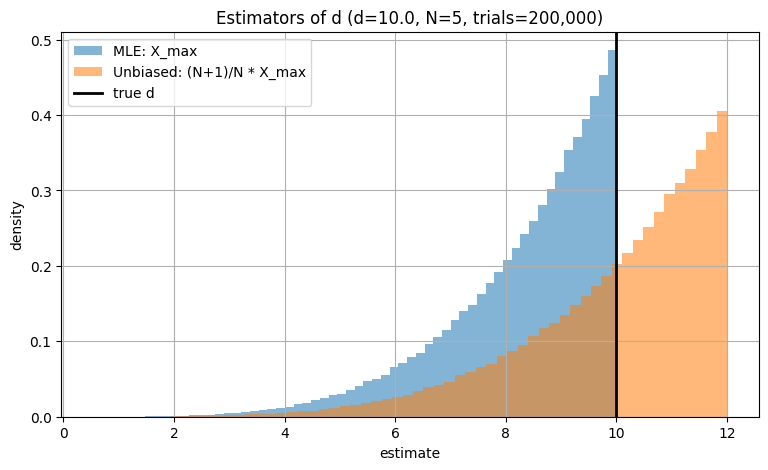

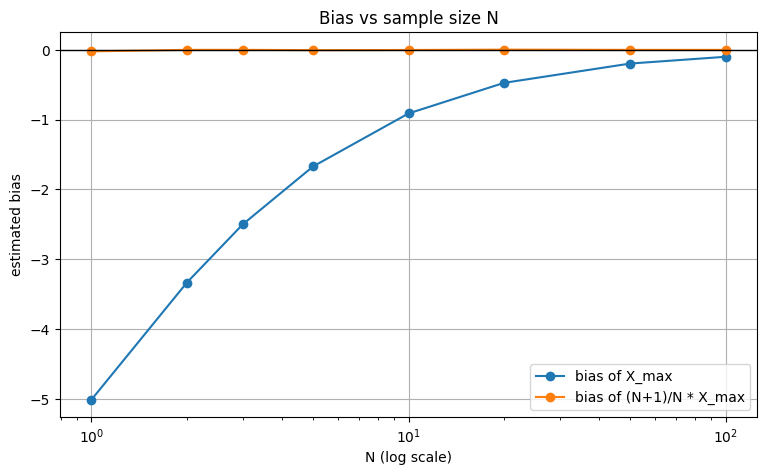

,N,bias_mle_xmax,bias_unbiased_xmax
0,1,-5.010701,-0.021401
1,2,-3.333506,-0.000259
2,3,-2.500033,-0.000045
3,5,-1.670374,-0.004449
4,10,-0.911157,-0.002272
5,20,-0.473225,0.003114
6,50,-0.196459,-0.000388
7,100,-0.099391,-0.000385


In [7]:
# Histogram of the key estimators
fig, ax = plt.subplots()

bins = 60
ax.hist(ests["d_mle_xmax"], bins=bins, alpha=0.55, density=True, label="MLE: X_max")
ax.hist(ests["d_unbiased_xmax"], bins=bins, alpha=0.55, density=True, label="Unbiased: (N+1)/N * X_max")
ax.axvline(d_true, color="black", linewidth=2, label="true d")

ax.set_title(f"Estimators of d (d={d_true}, N={N}, trials={n_trials:,})")
ax.set_xlabel("estimate")
ax.set_ylabel("density")
ax.legend()
plt.show()


# Bias as a function of N
Ns = np.array([1, 2, 3, 5, 10, 20, 50, 100])
trials_per_N = 120_000

rows = []
for n in Ns:
    smp = draw_uniform_samples(d=d_true, n=int(n), n_trials=trials_per_N, rng=rng)
    e = estimators_from_samples(smp)
    rows.append(
        {
            "N": int(n),
            "bias_mle_xmax": np.mean(e["d_mle_xmax"]) - d_true,
            "bias_unbiased_xmax": np.mean(e["d_unbiased_xmax"]) - d_true,
        }
    )

bias_df = pd.DataFrame(rows)

fig, ax = plt.subplots()
ax.plot(bias_df["N"], bias_df["bias_mle_xmax"], marker="o", label="bias of X_max")
ax.plot(bias_df["N"], bias_df["bias_unbiased_xmax"], marker="o", label="bias of (N+1)/N * X_max")
ax.axhline(0.0, color="black", linewidth=1)
ax.set_xscale("log")
ax.set_xlabel("N (log scale)")
ax.set_ylabel("estimated bias")
ax.set_title("Bias vs sample size N")
ax.legend()
plt.show()

bias_df

## Confidence interval for $d$ (optional)

Because we know the exact sampling distribution of $X_{\max}$, we can invert it to get a confidence interval for $d$.

From the derivation:

$$F_{\max}(x)=\left(\frac{x}{d}\right)^N\quad (0\le x\le d).$$

Equivalently, the scaled maximum $U=\frac{X_{\max}}{d}$ has CDF $\mathbb{P}(U\le u)=u^N$ for $0\le u\le 1$.

For a two-sided $(1-\alpha)$ CI, pick $p_1=\alpha/2$ and $p_2=1-\alpha/2$ so that

$$\mathbb{P}\left(p_1^{1/N} \le \frac{X_{\max}}{d} \le p_2^{1/N}\right)=p_2-p_1=1-\alpha.$$

Given an observed $x_{\max}$, solve for $d$:

$$\boxed{\ \left[\frac{x_{\max}}{p_2^{1/N}},\ \frac{x_{\max}}{p_1^{1/N}}\right]\ }$$

Practical note: when $N$ is small, the upper endpoint can be very large (because $p_1$ is tiny), reflecting genuine uncertainty about the unseen tail beyond the maximum.

In [8]:
def ci_for_d_from_xmax(x_max: float, n: int, alpha: float = 0.05) -> tuple[float, float]:
    """Two-sided (1-alpha) CI for d using inversion of the max order statistic.

    CI = [x_max / (1-alpha/2)^(1/n), x_max / (alpha/2)^(1/n)]

    Note: requires 0 < x_max and n>=1.
    """
    if n < 1:
        raise ValueError("n must be >= 1")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")
    if x_max <= 0:
        raise ValueError("x_max must be > 0")

    p1 = alpha / 2
    p2 = 1 - alpha / 2

    lo = x_max / (p2 ** (1 / n))
    hi = x_max / (p1 ** (1 / n))
    return float(lo), float(hi)


# Example CI from a single observed sample
single_sample = rng.uniform(0.0, d_true, size=N)
x_max_obs = float(np.max(single_sample))
ci_lo, ci_hi = ci_for_d_from_xmax(x_max_obs, n=N, alpha=0.05)

print(f"Observed sample (N={N}) max = {x_max_obs:.4f}")
print(f"95% CI for d via X_max inversion: [{ci_lo:.4f}, {ci_hi:.4f}]  (true d={d_true})")


# Coverage check (should be close to 1 - alpha)
alpha = 0.05
cover_trials = 40_000
smp = draw_uniform_samples(d=d_true, n=N, n_trials=cover_trials, rng=rng)
xm = smp.max(axis=1)

p1 = alpha / 2
p2 = 1 - alpha / 2
ci_lo = xm / (p2 ** (1 / N))
ci_hi = xm / (p1 ** (1 / N))
coverage = np.mean((ci_lo <= d_true) & (d_true <= ci_hi))

print(f"Empirical coverage over {cover_trials:,} trials (target={1-alpha:.3f}): {coverage:.3f}")

Observed sample (N=5) max = 4.6975
95% CI for d via X_max inversion: [4.7213, 9.8238]  (true d=10.0)
Empirical coverage over 40,000 trials (target=0.950): 0.951


## Conclusion

- The MLE for $d$ under $\mathrm{Uniform}(0,d)$ is $X_{\max}$, but it is biased downward:
  $$\mathbb{E}[X_{\max}] = \frac{N}{N+1}d.$$
- A simple unbiased correction is:
  $$\hat d = \frac{N+1}{N}X_{\max}.$$
- You can also get an exact CI for $d$ by inverting the distribution of $X_{\max}$.

### Practical checklist
- Always report $N$ and the observed maximum $x_{\max}$.
- If you need an unbiased point estimate, use $(N+1)/N\cdot x_{\max}$.
- If you need uncertainty quantification, prefer the inverted-CDF CI based on $X_{\max}$.
- Sanity-check with simulation when teaching/learning (as done above).